<a href="https://colab.research.google.com/github/harnalashok/hadoop/blob/main/spark_streaming_by_pictures.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Important**

>When running a Spark Streaming program locally, **do not use** “local” or “local[1]” as the master URL. Either of these means that only one thread will be used for running tasks locally. If you are using an input DStream based on a receiver (e.g. sockets, Kafka, etc.), then the single thread will be used to run the receiver, leaving no thread for processing the received data. Hence, when running locally, always use “local[n]” as the master URL, where n > number of receivers to run (see Spark Properties for information on how to set the mast

Datastreaming applications make it easy to collect, process, and analyze real-time, streaming data so you can get timely insights and react quickly to new information. They offer key capabilities to cost-effectively process streaming data at any scale, along with the flexibility to choose the tools that best suit the requirements of your application. One can ingest real-time data such as video, audio, application logs, website clickstreams, and IoT telemetry data for machine learning, analytics, and other applications. These enable you to process and analyze data as it arrives and respond instantly instead of having to wait until all your data is collected before the processing can begin.


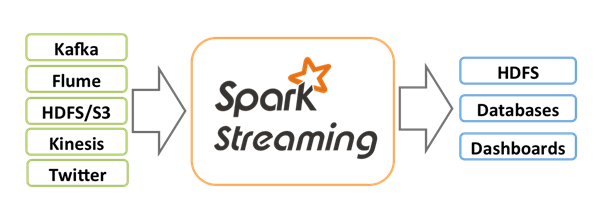

<b>DStreams</b>

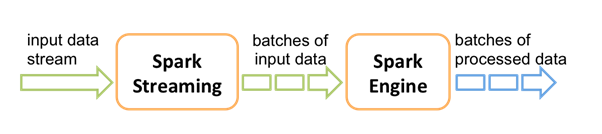

Spark Streaming provides a high-level abstraction called discretized stream or DStream, which represents a continuous stream of data. DStreams can be created either from input data streams from sources such as Kafka, and Kinesis, or by applying high-level operations on other DStreams. Internally, a DStream is represented as a sequence of RDDs.

**Spark Streaming Context** <br>
SSC is the Entry point for all spark streaming operations. This object must be created before any streaming is to begin.

DStream: <br>It is a high level Discretized Streaming abstraction.

<b>Stream Processing steps</b>

After a Streaming context is defined, 
After a context is defined, further steps are:

> **Define** the input sources by creating input DStreams.<br>
> **Define** the streaming computations by applying transformation and output operations to DStreams.<br>
> **Start** receiving data and processing it using streamingContext.start().<br>
>**Wait** for the processing to be stopped (manually or due to any error) using streamingContext.awaitTermination().<br>
> The processing can be manually stopped using streamingContext.stop().


 <b>DStream Internally:</b>  
 A DStream is represented by a continuous series of RDDs, which is Spark’s abstraction of an immutable, distributed dataset 

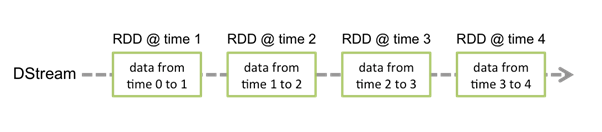

<b>Operations on DStreams</b><br>
Any operation applied on a DStream translates to operations on the underlying RDDs. For example, in the earlier example of converting a stream of lines to words, the flatMap operation is applied on each RDD in the lines DStream to generate the RDDs of the words DStream.

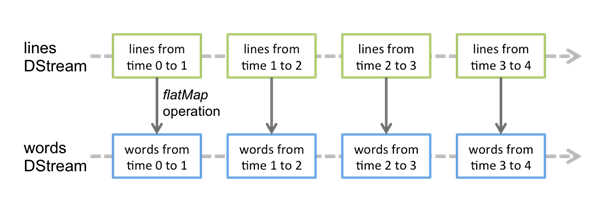

**Receiver**  
Every input DStream (except file stream) is associated with a **Receiver** object which receives the data from a source and stores it in Spark’s memory for processing

**Data Sources:**<br>
Spark Streaming provides two categories of built-in streaming sources.
> Basic sources: Sources directly available in the StreamingContext API. Examples: file systems, and socket connections.<br>
> Advanced sources: Sources like Kafka, Kinesis, etc. are available through extra utility classes. These require linking against extra dependencies.


**How Directories are Monitored**

Spark Streaming will monitor the directory dataDirectory and process any files created in that directory.

> A simple directory can be monitored, such as "hdfs://namenode:8040/logs/". All files directly under such a path will be processed as they are discovered.
> A POSIX glob pattern can be supplied, such as "hdfs://namenode:8040/logs/2017/*". Here, the DStream will consist of all files in the directories matching the pattern. That is: it is a pattern of directories, not of files in directories.<br>
>All files must be in the same data format.<br>
>A file is considered part of a time period based on **its modification time**, not its creation time.<br>
>Once processed, changes to a file within the current window will not cause the file to be reread. That is: **updates to file are ignored**.<br>
> The more files under a directory, the longer it will take to scan for changes — even if no files have been modified.

**Receiver Reliability**

There can be two kinds of data sources based on their reliability. Sources (like Kafka) allow the transferred data to be acknowledged. If the system receiving data from these reliable sources acknowledges the received data correctly, it can be ensured that no data will be lost due to any kind of failure. This leads to two kinds of receivers:

> Reliable Receiver - A reliable receiver correctly sends acknowledgment to a reliable source when the data has been received and stored in Spark with replication.<br>
> Unreliable Receiver - An unreliable receiver does not send acknowledgment to a source. This can be used for sources that do not support acknowledgment, or even for reliable sources when one does not want or need to go into the complexity of acknowldgement.

Data Dtream as an un-bounded table

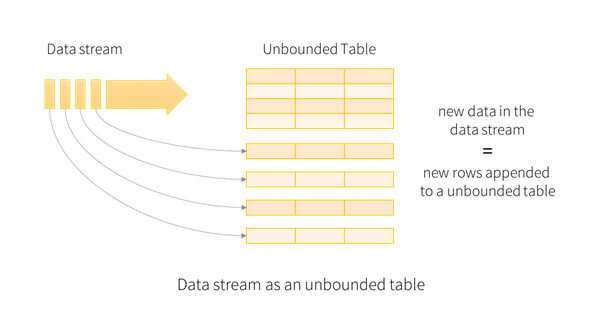

A qery on the input will generate the “Result Table”. Every trigger interval (say, every 1 second), new rows get appended to the Input Table, which eventually updates the Result Table. Whenever the result table gets updated, we would want to write the changed result rows to an external sink.

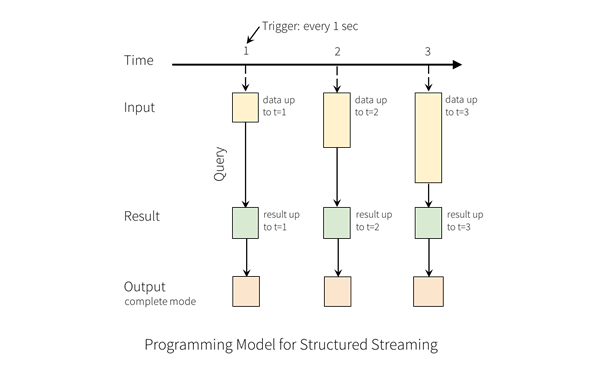

**Output modes**

The “Output” is defined as what gets written out to the external storage. The output can be defined in a different mode:

>Complete Mode - The entire updated Result Table will be written to the external storage. It is up to the storage connector to decide how to handle writing of the entire table. 

> Append Mode - Only the new rows appended in the Result Table since the last trigger will be written to the external storage. This is applicable only on the queries where existing rows in the Result Table are not expected to change. For example, tweets are arriving. As tweets arrive, its sentiments are labeled and displayed. Sentiments of already labelled tweets will not change. Hence 'append' mode will display labels of only fresh tweets.

>Update Mode - Only the rows that were updated in the Result Table since the last trigger will be written to the external storage. Note that this is different from the Complete Mode in that this mode only outputs the rows that have changed since the last trigger. If the query doesn’t contain aggregations, it will be equivalent to Append mode.

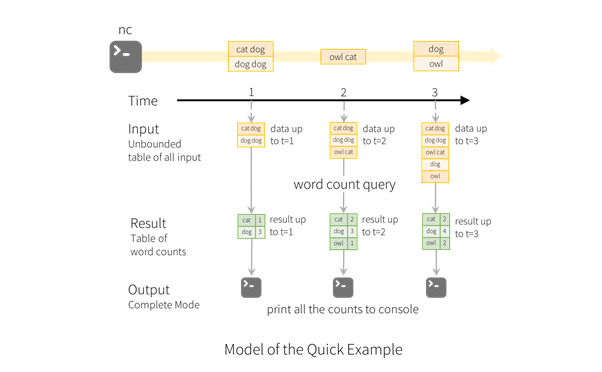

**Handling Event-time and Late Data**  
Event-time is the time embedded in the data itself. For many applications, you may want to operate on this event-time. For example, if you want to get the number of events generated by IoT devices every minute, then you probably want to use the time when the data was generated (that is, event-time in the data), rather than the time Spark receives them. This event-time is very naturally expressed in this model – each event from the devices is a row in the table, and event-time is a column value in the row. This allows window-based aggregations (e.g. number of events every minute) to be just a special type of grouping and aggregation on the event-time column – each time window is a group and each row can belong to multiple windows/groups. Therefore, such event-time-window-based aggregation queries can be defined consistently on both a static dataset (e.g. from collected device events logs) as well as on a data stream, making the life of the user much easier.

**Window operations on Event Time**

Aggregations over a **sliding event-time window** are straightforward with Structured Streaming and are very similar to grouped aggregations. In a grouped aggregation, aggregate values (e.g. counts) are maintained for each unique value in the user-specified grouping column. In case of window-based aggregations, aggregate values are maintained for each window the event-time of a row falls into. Let’s understand this with an illustration.

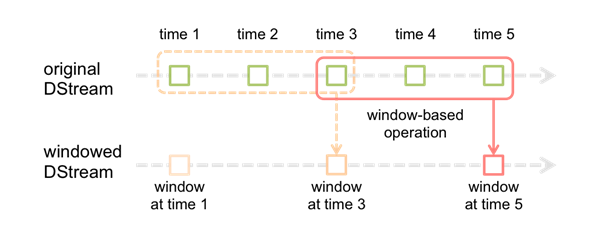

As shown in the figure, every time the window slides over a source DStream, the source RDDs that fall within the window are combined and operated upon to produce the RDDs of the windowed DStream. In this specific case, the operation is applied over the last 3 time units of data, and slides by 2 time units. This shows that any window operation needs to specify two parameters.

>window length - The duration of the window (3 in the figure).<br>
>sliding interval - The interval at which the window operation is performed (2 in the figure).


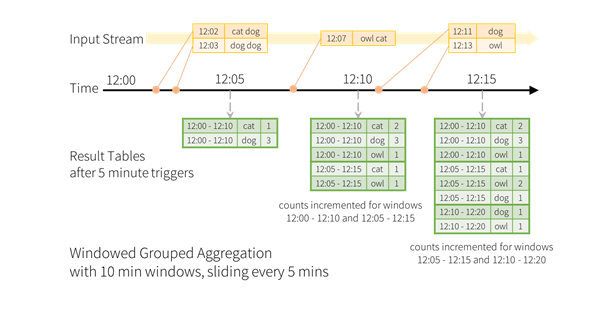

<b>Other points to remember:</b><br>
DStreams are executed lazily by the output operations, just like RDDs are lazily executed by RDD actions. Specifically, RDD actions inside the DStream output operations force the processing of the received data. Hence, if your application does not have any output operation then nothing will get executed. The system will simply receive the data and discard it.

## End-to-end Exactly once tolerance
Refer [here](https://docs.microsoft.com/en-us/azure/hdinsight/spark/apache-spark-streaming-exactly-once)

Stream processing applications take different approaches to how they handle reprocessing messages after some failure in the system:

> At least once: Each message is guaranteed to be processed, but it may get processed more than once. <br>
> At most once: Each message may or may not be processed. If a message is processed, it's only processed once. <br>
> Exactly once: Each message is guaranteed to be processed once and only once.<br>

Spark 2.3, we have introduced a new low-latency processing mode called **Continuous Processing**, which can achieve end-to-end latencies as low as 1 millisecond with **at-least-once guarantees**.


### How to achive Exactly once processing

1. Replayable sources: The source your Spark Streaming application is reading your events from must be replayable. This means that in cases where the message was retrieved but then the system failed before the message could be persisted or processed, the source must provide the same message again.
2. Reliable receivers: In Spark Streaming, sources like Kafka have reliable receivers, where each receiver keeps track of its progress reading the source. A reliable receiver persists its state into fault-tolerant storage,  in Spark Streaming checkpoints written to HDFS. If such a receiver fails and is later restarted, it can pick up where it left off.
3. Use the Write-Ahead Log: Spark Streaming supports the use of a Write-Ahead Log, where each received event is first written to Spark's checkpoint directory in fault-tolerant storage and then stored in a Resilient Distributed Dataset (RDD).
4. Use idempotent sinks
The destination sink to which your job writes results must be able to handle the situation where it's given the same result more than once. The sink must be able to detect such duplicate results and ignore them. An idempotent sink can be called multiple times with the same data with no change of state. 
You can create idempotent sinks by implementing logic that first checks for the existence of the incoming result in the datastore. If the result already exists, the write should appear to succeed from the perspective of your Spark job, but in reality your data store ignored the duplicate data. If the result doesn't exist, then the sink should insert this new result into its storage.


### A few notes
1. By default, Structured Streaming from file based sources requires you to specify the schema, rather than rely on Spark to infer it automatically. This restriction ensures a consistent schema will be used for the streaming query, even in the case of failures. For ad-hoc use cases, you can reenable schema inference by setting spark.sql.streaming.schemaInference to true.
2. You can apply all kinds of operations on streaming DataFrames/Datasets – ranging from untyped, SQL-like operations (e.g. select, where, groupBy), to typed RDD-like operations (e.g. map, filter, flatMap). See the SQL programming guide for more details. Let’s take a look at a few example operations that you can use.
3. You can also register a streaming DataFrame/Dataset as a temporary view and then apply SQL commands on it.
4. Note, you can identify whether a DataFrame/Dataset has streaming data or not by using `df.isStreaming`.

In [ ]:
############################